# **MODELO S**
Com data augmentation

## **Importações e Definições de Seed**

Primeiro, importamos as bibliotecas necessárias e definimos a seed para garantir a reprodutibilidade dos resultados.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2024-06-22 18:28:35.768302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 18:28:36.967347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## **Definição dos Diretórios do Dataset e Tamanho da Imagem**

Definimos os diretórios dos conjuntos de dados e o tamanho das imagens.
Juntamos as imagens de treino todas na mesma pastas para simplificar o carregamento.

In [3]:
train_dir = '../Data/train'
validation_dir = '../Data/validation5'
test_dir = '../Data/test'
IMG_SIZE = 32
BATCH_SIZE = 32

### Funções para Visualizaçao de Resultados

In [4]:
def plot_training_history(history, test_number, trial_number):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'../plots/s{test_number}/trial_{trial_number}_plot.png')

    plt.close()
    return


def predict_with_best_model(model, dataset):
    y_true = []
    y_pred = []

    for x, y in dataset:
        y_true.extend(tf.argmax(y, axis=1))
        y_pred.extend(tf.argmax(model.predict(x), axis=1))

    return y_true, y_pred

# Função para plotar matriz de confusão
def plot_confusion_matrix(y_true, y_pred, class_names, test_number,trial_number):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'../plots/s{test_number}/trial_{trial_number}_confusion_matrix.png')

    plt.close()
    return

## **Carregamento dos Conjuntos de Dados**

In [6]:
train_dataset = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    seed=SEED
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    seed=SEED
)

test_dataset = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    seed=SEED
)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


## **Definição da data augmentation**

In [104]:
# Define data augmentation using keras.Sequential
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
    ]
)

2024-06-20 21:28:46.625793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


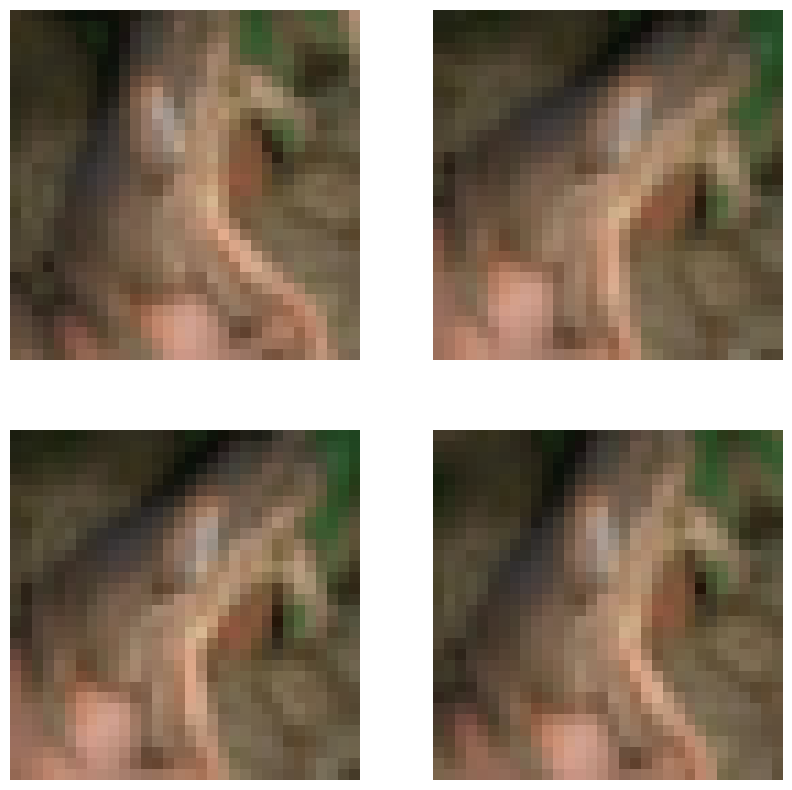

In [105]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Normalização dos Conjuntos de Dados**

Normalizamos os conjuntos de dados para garantir que os valores dos pixels estejam na faixa de 0 a 1 o que são mais adequados ao modelo de treino.

In [7]:
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(
    lambda x, y: (normalization_layer(x), y)
)

validation_dataset = validation_dataset.map(
    lambda x, y: (normalization_layer(x), y)
)

test_dataset = test_dataset.map(
    lambda x, y: (normalization_layer(x), y)
)

# Construção do modelo 1 
Baseado no modelo 3 dos testes anteriores.

In [83]:
num_filters_1 = 32
num_filters_2 = 32
num_filters_3 = 64
optimizer_name = 'Adam'
learning_rate = 3e-4

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(data_augmentation)

# Primeira camada convolucional
model.add(layers.Conv2D(num_filters_1, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Segunda camada convolucional
model.add(layers.Conv2D(num_filters_2, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Terceira camada convolucional
model.add(layers.Conv2D(num_filters_3, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Camadas flatten e dense
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

optimizer = getattr(optimizers, optimizer_name)(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## Treinar o Modelo

In [84]:
model_path = '../models/s3/model_trial_1_DA_CPbest.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
    ),    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-5
    )
]

history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history, '3', '1_DA')

Epoch 1/40


2024-06-20 19:24:07.238341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_15_1/dropout_49_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2456 - loss: 2.5211
Epoch 1: val_loss improved from inf to 1.51678, saving model to ../models/s3/model_trial_3_1_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.2456 - loss: 2.5205 - val_accuracy: 0.4520 - val_loss: 1.5168 - learning_rate: 3.0000e-04
Epoch 2/40
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3847 - loss: 1.7399
Epoch 2: val_loss improved from 1.51678 to 1.34610, saving model to ../models/s3/model_trial_3_1_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.3848 - loss: 1.7398 - val_accuracy: 0.5187 - val_loss: 1.3461 - learning_rate: 3.0000e-04
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4414 - loss: 1.5521
Epoch 3: val_loss did not improve from 1.34610
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.4414 - loss: 1.5521 - val_accuracy: 0.5085 - val_loss: 1.3962 - learning_rate: 3.0000e-04
Epoch 4/40
1249/1250 ━━━━━━━

![](../plots/s3/trial_1_DA_plot.png)

Como estamos a ter resultados semelhantes ao de sem data augmentation vamos tentar mais algumas épocas.


In [85]:
model = models.load_model('../models/s3/model_trial_1_DA_CPbest.keras')
model_path = '../models/s3/model_trial_1_1_DA_CPbest.keras'
callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=0
    ),
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        mode='max',
        factor=0.1,  
        patience=5,  
        min_lr=1e-6
    )
]

history = model.fit(
    train_dataset,
    epochs=50,  
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history, '3', '1_1_DA')

Epoch 1/50


2024-06-20 19:48:56.949704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_15_1/dropout_49_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.6446 - loss: 1.0086 - val_accuracy: 0.6885 - val_loss: 0.8941 - learning_rate: 3.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6438 - loss: 1.0113 - val_accuracy: 0.6413 - val_loss: 1.0518 - learning_rate: 3.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6491 - loss: 0.9977 - val_accuracy: 0.7056 - val_loss: 0.8441 - learning_rate: 3.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6518 - loss: 0.9971 - val_accuracy: 0.7004 - val_loss: 0.8591 - learning_rate: 3.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6491 - loss: 0.9934 - val_accuracy: 0.7078 - val_loss: 0.8384 - learning_rate: 3.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6500 - loss: 0.9965 - val_accuracy: 0.6859 - val_loss: 0.8986 - learning_rate: 3.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/

![](../plots/s3/trial_1_1_DA_plot.png)

### Verificar resultados

In [88]:
# Avaliar o melhor modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\tPrecião no conjunto de Teste: {test_acc:.4f}')
print(f'\tPerda no conjunto de Teste:   {test_loss:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7345 - loss: 0.7642
	Precião no conjunto de Teste: 0.7287
	Perda no conjunto de Teste:   0.7876


# Alterar data augmentation

Como não estamos a conseguir melhores resultados vamos tentar aumentar um pouco mais as transformações aplicadas as imagens.

In [96]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
    ]
)

## Modelo 2
No modelo aumentamos um pouco o learning rate para ver se conseguimos acelerar a convergência do treinamento e melhorar o desempenho do modelo. Este ajuste pode ajudar o modelo a aprender mais rapidamente. Embora possa não conseguir chegar a ajustes finos.

In [115]:
num_filters_1 = 32
num_filters_2 = 32
num_filters_3 = 64
optimizer_name = 'Adam'
learning_rate = 5e-3

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(data_augmentation)

# Primeira camada convolucional
model.add(layers.Conv2D(num_filters_1, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Segunda camada convolucional
model.add(layers.Conv2D(num_filters_2, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Segunda camada convolucional
model.add(layers.Conv2D(num_filters_3, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Camadas flatten e dense
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

optimizer = getattr(optimizers, optimizer_name)(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/home/patinhooh/miniconda3/envs/ia/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [117]:
model_path = '../models/s3/model_trial_2_DA_CPbest.keras'
callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=0
    ),
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=15
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        mode='max',
        factor=0.15,  
        patience=10,  
        min_lr=1e-6
    )
]

history = model.fit(
    train_dataset,
    epochs=100,  
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history, '3', '2_DA')

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.3374 - loss: 1.8226 - val_accuracy: 0.3998 - val_loss: 1.6449 - learning_rate: 0.0050
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.4252 - loss: 1.6037 - val_accuracy: 0.4350 - val_loss: 1.6337 - learning_rate: 0.0050
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.4343 - loss: 1.5690 - val_accuracy: 0.5037 - val_loss: 1.3998 - learning_rate: 0.0050
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.4523 - loss: 1.5376 - val_accuracy: 0.5102 - val_loss: 1.3870 - learning_rate: 0.0050
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.4549 - loss: 1.5275 - val_accuracy: 0.5310 - val_loss: 1.3140 - learning_rate: 0.0050
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4638 - loss: 1.5127 - val_accuracy: 0.5581 - val_loss: 1.2758 - learning_rate: 0.0050
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step -

![](../plots/s3/trial_2_DA_plot.png)

Parece que o aumento do learning rate foi prejudicial ao modelo pois so aumentou a precisao quando o `ReduceLROnPlateau` foi ativo. Vamos ajustar os callbacks para tentar ajustar melhor o modelos.

In [118]:
model_path = '../models/s3/model_trial_2_1_DA_CPbest.keras'
callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=0
    ),
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=15
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        mode='max',
        factor=0.2, # aumentado
        patience=5,  # reduzido
        min_lr=1e-6
    )
]

history = model.fit(
    train_dataset,
    epochs=44,  # reduzido para chegar no maximo a 100 no total
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history, '3', '2_1_DA')

Epoch 1/44
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6041 - loss: 1.1360 - val_accuracy: 0.6465 - val_loss: 1.0351 - learning_rate: 1.1250e-04
Epoch 2/44
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6109 - loss: 1.1268 - val_accuracy: 0.6436 - val_loss: 1.0394 - learning_rate: 1.1250e-04
Epoch 3/44
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6084 - loss: 1.1274 - val_accuracy: 0.6357 - val_loss: 1.0618 - learning_rate: 1.1250e-04
Epoch 4/44
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.6066 - loss: 1.1255 - val_accuracy: 0.6474 - val_loss: 1.0188 - learning_rate: 1.1250e-04
Epoch 5/44
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6078 - loss: 1.1216 - val_accuracy: 0.6478 - val_loss: 1.0276 - learning_rate: 1.1250e-04
Epoch 6/44
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6075 - loss: 1.1243 - val_accuracy: 0.6480 - val_loss: 1.0305 - learning_rate: 1.1250e-04
Epoch 7/44
1250/1250 ━━━━━━━━━━━━━━━━━━━

![](../plots/s3/trial_2_1_DA_plot.png)

Aqui podemos ver que o modelo já estagnou ent vamos ter de mudar um pouco a estrutura pois esta está a ter dificultade em extrair filtros que consigam responder ao problema com muitos dados.

## Modelo **3**
Foram tentados alguns paramentros diferentes porem descartamos este modelo

## Modelo **4** 

In [121]:
num_filters_1 = 64  # aumentado
num_filters_2 = 64  # aumentado
num_filters_3 = 128  # aumentado
optimizer_name = 'Adam'
learning_rate = 1e-3  # reduzido


model = models.Sequential()
model.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(data_augmentation)

# First convolutional layer
model.add(layers.Conv2D(num_filters_1, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Second convolutional layer
model.add(layers.Conv2D(num_filters_2, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Third convolutional layer
model.add(layers.Conv2D(num_filters_3, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Optimizer and compilation
optimizer = getattr(optimizers, optimizer_name)(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_27 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,167,818 (4.45 MB)

 Trainable params: 1,167,306 (4.45 MB)

 Non-trainable params: 512 (2.00 KB)

In [122]:
model_path = '../models/s3/model_trial_4_DA_CPbest.keras'
callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=15
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        mode='max',
        factor=0.2,  
        patience=5,  
        min_lr=1e-6
    )
]

history = model.fit(
    train_dataset,
    epochs=100,  
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history, '3', '4_DA')

Epoch 1/100


2024-06-20 23:24:43.696246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_34_1/dropout_99_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3023 - loss: 2.4524
Epoch 1: val_accuracy improved from -inf to 0.38450, saving model to ../models/s3/model_trial_3_3_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.3025 - loss: 2.4516 - val_accuracy: 0.3845 - val_loss: 1.7699 - learning_rate: 0.0010
Epoch 2/100
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4472 - loss: 1.5387
Epoch 2: val_accuracy improved from 0.38450 to 0.52670, saving model to ../models/s3/model_trial_3_3_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4472 - loss: 1.5387 - val_accuracy: 0.5267 - val_loss: 1.3493 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4891 - loss: 1.4325
Epoch 3: val_accuracy did not improve from 0.52670
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.4891 - loss: 1.4325 - val_accuracy: 0.4755 - val_loss: 1.5830 - learning_rate: 0.0010
Epoch 4/100
1248/1250 ━━━

# Avaliação do modelo 4

![](../plots/s3/trial_4_DA_plot.png)

In [123]:
# Avaliar o melhor modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\tPrecião no conjunto de Teste: {test_acc:.4f}')
print(f'\tPerda no conjunto de Teste:   {test_loss:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7722 - loss: 0.6577
	Precião no conjunto de Teste: 0.7636
	Perda no conjunto de Teste:   0.6844


Estamos no caminho certo, agr o modelo ja esta a chegar valores melhores que ao modelo sem data augmentation.

## Modelo **5**
Neste modelo tentamos recuperar o que tinhamos constatado anteriormente, a melhor performance quando a primeira camada é composta por 32 filtros e aumentar os restantes.

In [140]:
num_filters_1 = 32 # reduzido
num_filters_2 = 128  # aumentado
num_filters_3 = 256 # aumentado
optimizer_name = 'Adam'
learning_rate = 1e-3 


model = models.Sequential()
model.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(data_augmentation)

# First convolutional layer
model.add(layers.Conv2D(num_filters_1, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Second convolutional layer
model.add(layers.Conv2D(num_filters_2, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Third convolutional layer
model.add(layers.Conv2D(num_filters_3, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Optimizer and compilation
optimizer = getattr(optimizers, optimizer_name)(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_27 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 13, 13, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,437,514 (9.30 MB)

 Trainable params: 2,436,682 (9.30 MB)

 Non-trainable params: 832 (3.25 KB)

In [141]:
model_path = '../models/s3/model_trial_5_DA_CPbest.keras'
callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=15
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        mode='max',
        factor=0.05,  
        patience=10,  
        min_lr=1e-5
    )
]

history = model.fit(
    train_dataset,
    epochs=100,  
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history, '3', '5_DA')

Epoch 1/100


2024-06-21 00:38:08.085395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_42_1/dropout_131_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3179 - loss: 2.6240
Epoch 1: val_accuracy improved from -inf to 0.46760, saving model to ../models/s3/model_trial_3_4_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.3179 - loss: 2.6235 - val_accuracy: 0.4676 - val_loss: 1.6311 - learning_rate: 0.0010
Epoch 2/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4530 - loss: 1.5346
Epoch 2: val_accuracy improved from 0.46760 to 0.51350, saving model to ../models/s3/model_trial_3_4_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4530 - loss: 1.5345 - val_accuracy: 0.5135 - val_loss: 1.9040 - learning_rate: 0.0010
Epoch 3/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4876 - loss: 1.4496
Epoch 3: val_accuracy did not improve from 0.51350
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4876 - loss: 1.4496 - val_accuracy: 0.4829 - val_loss: 1.5753 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━

![](../plots/s3/trial_5_DA_plot.png)


Como o modelo subiu um degrau com o diminuir do learning rate então vamos tentar treinar mais umas épocas.

In [144]:
model = models.load_model('../models/s3/model_trial_5_DA_CPbest.keras')
model_path = '../models/s3/model_trial_5_1_DA_CPbest.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        mode='max',
        factor=0.1,  
        patience=3,  
        min_lr=1e-5
    )
]

history = model.fit(
    train_dataset,
    epochs=50,  
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history, '3', '5_1_DA')

Epoch 1/50


2024-06-21 01:40:23.246522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_42_1/dropout_131_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7597 - loss: 0.6974
Epoch 1: val_accuracy improved from -inf to 0.79270, saving model to ../models/s3/model_trial_3_4_1_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.7597 - loss: 0.6974 - val_accuracy: 0.7927 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7650 - loss: 0.6904
Epoch 2: val_accuracy did not improve from 0.79270
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.7650 - loss: 0.6904 - val_accuracy: 0.7917 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 3/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7647 - loss: 0.6902
Epoch 3: val_accuracy improved from 0.79270 to 0.80230, saving model to ../models/s3/model_trial_3_4_1_DA_CPbest.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.7647 - loss: 0.6902 - val_accuracy: 0.8023 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 4/50
1248/1250 ━━

# Avaliação do modelo 4
- 86 épocas no total
- Precisão no conjunto de Validação: 81.49%
- Perda no conjunto de Validação: 0.5805

In [8]:
model = models.load_model('../models/s3/model_trial_5_1_DA_CPbest.keras')
y_test, pred = predict_with_best_model(model, test_dataset)

2024-06-22 18:30:06.837999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

2024-06-22 18:30:31.686168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\tPrecião no conjunto de Teste: {test_acc:.4f}')
print(f'\tPerda no conjunto de Teste:   {test_loss:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8101 - loss: 0.5772
	Precião no conjunto de Teste: 0.8078
	Perda no conjunto de Teste:   0.6051


- Precisão no conjunto de Teste: 80.8%
- Perda no conjunto de Teste: 0.7643

O modelo apresenta um desempenho bom.

In [10]:
acc = accuracy_score(y_true =  y_test, y_pred = pred)
print(f'Accuracy : {np.round(acc*100,2)}%')

print("\nPrecision:")   
precision = precision_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'\tMacro:    {np.round(precision*100,2)}%')

precision = precision_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'\tWeighted: {np.round(precision*100,2)}%')

print("\nRecall:")
recall = recall_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'\tMacro:    {np.round(recall*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'\tWeighted: {np.round(recall*100,2)}%')
print()

print("\nF1-score:")
f1 = f1_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'\tMacro:    {np.round(f1*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'\tWeighted: {np.round(f1*100,2)}%')

Accuracy : 80.78%

Precision:
	Macro:    80.8%
	Weighted: 80.8%

Recall:
	Macro:    80.78%
	Weighted: 80.78%


F1-score:
	Macro:    80.42%
	Weighted: 80.42%


Resultado Precisão:
- Macro: 80.8%
- Ponderada: 80.8%

A precisão macro e weighted são iguais, indicando que as classes são balanceadas. A precisão de aproximadamente 81% mostra que, quando o modelo prevê uma classe como positiva, ele está correto em 81% dos casos. Indicando que o modelo tem um bom desempenho uniforme em todas as classes.

<br>

Resultado Revocação:
- Macro: 80.78%
- Ponderada: 80.78%

As métricas de precisão e recall são praticamente iguais, o que é positivo. As versões macro e ponderada são iguais. Logo, o modelo tem uma capacidade uniforme de identificar corretamente as instâncias de cada classe.

<br>

Resultado F1-Score:
- Macro: 80.42%
- Ponderada: 80.42%

O valor de 80.42% para ambas as versões indica que o modelo mantém um bom equilíbrio entre precisão e recall, embora seja ligeiramente menor, indicando uma pequena margem para melhorias.

In [11]:
class_names = ['Avião', 'Automovel', 'Passaro', 'Gato', 'Viado',
                'Cão', 'Sapo', 'Cavalo', 'Barco', 'Camião']
plot_confusion_matrix(y_test, pred, class_names, '3', '5_1_DA')

![](../plots/s3/trial_5_1_DA_confusion_matrix.png)

# Conclusões Finais

O modelo agora apresenta uma acurácia, precisão, recall e F1-score acima de 80%, indicando uma melhora considerável com data augmentation. Mas seria possivel continuar monitorando e ajustando hiperparâmetros, além de realizar validação cruzada, podem levar a melhorias adicionais e garantir a estabilidade do modelo em diferentes conjuntos de dados.

Porém para este projeto iremos ficar por aqui com os modelos S